# Frontal Detection Analysis (Total Precip)
Testing sensitivity to removing low precip days

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from scipy import stats

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='20GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your dask-local directory
    resource_spec='select=1:ncpus=1:mem=20GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='06:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 10 or 20 nodes (10 or 20 dask workers)
cluster.scale(20)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36120 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/36120/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/36120/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.51:36114,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/36120/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read landfrac to subset land points

In [4]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
landfrac_file = 'landfrac_1deg_bil.nc'

In [5]:
landfrac = xr.open_dataarray(postprocessing_filepath+landfrac_file)

## Read and process 3hrly precipitation

In [6]:
def process_PRECT(path, file, landfrac):
    PRECT_1deg = xr.open_dataarray(path+file, chunks={'time':600, 'lat':10, 'lon':20})
    
    # subset for a 15-year climatology (if applicable)
    if PRECT_1deg.shape[0] > 43800:
        PRECT_1deg = PRECT_1deg[:43800]
    
    # subset for land only (optional; comment out to use whole domain)
    #PRECT_1deg = PRECT_1deg.where(landfrac > 0)
    
    # Daily total precipitation (note .resample is computationally expensive)
    #PRECT_day = PRECT_1deg.resample(time='D').sum(dim='time')
    
    return(PRECT_1deg)

In [7]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_bil.nc' # bilinear interpolation, units are m/s
#PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_cons.nc' # conservative regridding
PRECT = process_PRECT(postprocessing_filepath, PRECT_file, landfrac)

PRECT_file_rcp = 'PRECT_3hravg_NA_rcp85_1deg_bil.nc'
PRECT_rcp = process_PRECT(postprocessing_filepath, PRECT_file_rcp, landfrac)

#### Test sensitivity of time shift with `cdo daysum` and compare to xarray `resample`

In [9]:
# file made with xarray resample
PRECT_day_sum_file = 'PRECT_day_sum_hist_rcp26.nc'
PRECT_day_sum = xr.open_dataarray(postprocessing_filepath+PRECT_day_sum_file, chunks={'time':100, 'lat':10, 'lon':20})
PRECT_day_sum = PRECT_day_sum[:-1]
PRECT_day_sum

,Array,Chunk
Bytes,400.50 MiB,156.25 kiB
Shape,"(5475, 68, 141)","(100, 10, 20)"
Count,6161 Tasks,3080 Chunks
Type,float64,numpy.ndarray


In [10]:
# something slightly weird here...there shouldn't be any negative PRECT daily sum values
PRECT_day_sum.isel(time=1).min().values

array(-1.19617423e-45)

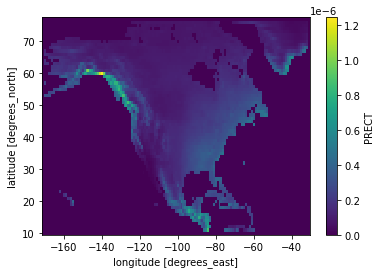

In [16]:
PRECT_day_sum.mean(dim='time').plot()

In [14]:
# file made with CDO
# these need to be opened as dataset for some reason (time bounds?)
PRECT_daysum_file = 'PRECT_daysum_NA_hist_rcp26_1deg_bil.nc'
PRECT_daysum_ds = xr.open_dataset(postprocessing_filepath+PRECT_daysum_file, chunks={'time':100, 'lat':10, 'lon':20})
PRECT_daysum = PRECT_daysum_ds.PRECT[:5475]
PRECT_daysum

,Array,Chunk
Bytes,400.50 MiB,156.25 kiB
Shape,"(5475, 68, 141)","(100, 10, 20)"
Count,6385 Tasks,3080 Chunks
Type,float64,numpy.ndarray


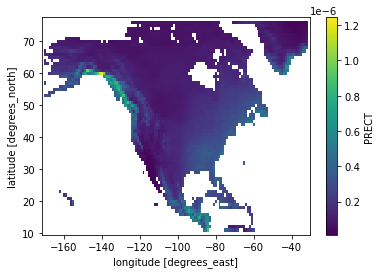

In [19]:
PRECT_daysum.where(landfrac > 0).mean(dim='time').plot()

In [20]:
# file made with CDO, time shift 1 hour backwards to account for CESM timestamp at end of 3hrly period
PRECT_daysum_file_shift = 'PRECT_daysum_shift_NA_hist_rcp26_1deg_bil.nc'
PRECT_daysum_shift_ds = xr.open_dataset(postprocessing_filepath+PRECT_daysum_file_shift, chunks={'time':100, 'lat':10, 'lon':20})
PRECT_daysum_shift = PRECT_daysum_shift_ds.PRECT[:5475]
PRECT_daysum_shift

,Array,Chunk
Bytes,400.50 MiB,156.25 kiB
Shape,"(5475, 68, 141)","(100, 10, 20)"
Count,6385 Tasks,3080 Chunks
Type,float64,numpy.ndarray


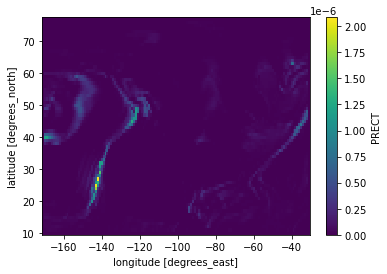

In [21]:
# comparing CDO files
# there is a difference in the daily sum due to time shift, which means the shift is important to include
# more precip on day 1 (time=0) in the shifted file because it includes an additional 3-hourly timestep
(PRECT_daysum_shift.isel(time=0) - PRECT_daysum.isel(time=0)).plot()

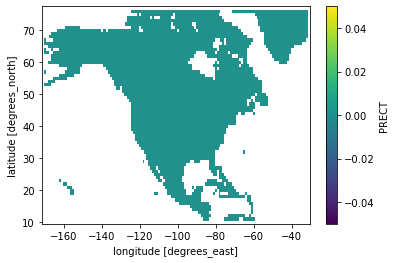

In [25]:
# comparing xarray resample / CDO daysum no time shift
# these should be the same over land without time shifting
# note also xarray version was already masked for land area
(PRECT_day_sum.isel(time=0) - PRECT_daysum.where(landfrac > 0).isel(time=0)).plot()

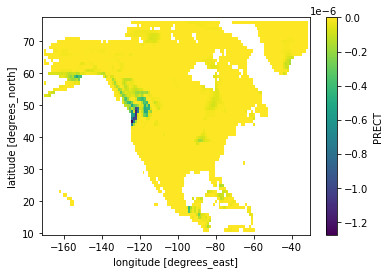

In [26]:
# comparing xarray resample / CDO daysum time shift
# xarray time values were not adjusted before resample so would expect this to be different
(PRECT_day_sum.isel(time=0) - PRECT_daysum_shift.where(landfrac>0).isel(time=0)).plot()

#### Verifying the filtering and upscaling process

In [105]:
# daily sum precip (convert m/s to mm over a day)
PRECT_daysum_mm = PRECT_daysum_shift * 1000*60*60*3

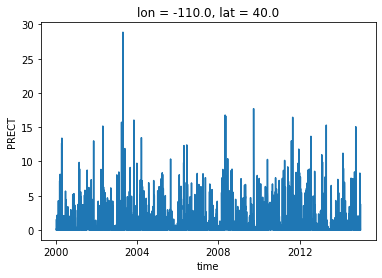

In [106]:
# pick a random land gridpoint to test timeseries analysis
PRECT_daysum_mm.sel(lat=40,lon=-110).plot()

In [107]:
# filter out days with less than 1 mm
PRECT_daysum_mm_filter = PRECT_daysum_mm.where(PRECT_daysum_mm > 1)

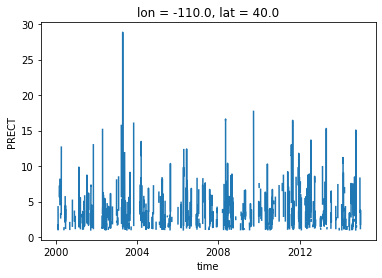

In [108]:
PRECT_daysum_mm_filter.sel(lat=40,lon=-110).plot()

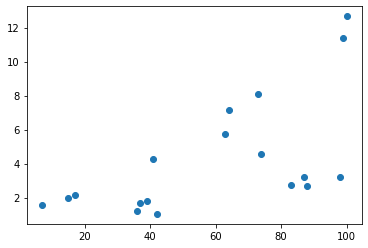

In [109]:
# first 100 days of filtered daily totals as a scatter plot
plt.scatter(np.linspace(1,100,100), PRECT_daysum_mm_filter.sel(lat=40,lon=-110)[:100], marker='o')

In [110]:
# upscale the daily filtered data to match 3hr frequency
# here's where the interpolation method is important to pay attention to
PRECT_daysum_mm_filter_upscaled = PRECT_daysum_mm_filter.resample(time="3H").interpolate('nearest')

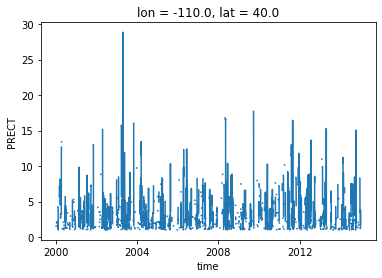

In [111]:
PRECT_daysum_mm_filter_upscaled.sel(lat=40,lon=-110).plot()

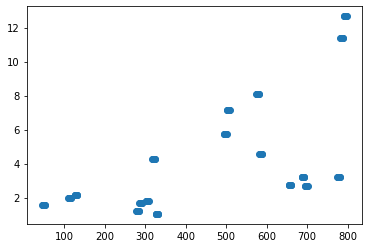

In [112]:
# first 100 days of filtered upscaled 3hrly data as a scatter plot
plt.scatter(np.linspace(1,800,800), PRECT_daysum_mm_filter_upscaled.sel(lat=40,lon=-110)[0:800], marker='o')

In [113]:
# daily time indices that are included in the first 100 days of filtered data
PRECT_daysum_mm_filter.time[:100].where(PRECT_daysum_mm_filter.sel(lat=40,lon=-110)[:100].notnull()).values

array([nan, nan, nan, nan, nan, nan,
       cftime.DatetimeNoLeap(2000, 1, 7, 12, 30, 0, 0, has_year_zero=True),
       nan, nan, nan, nan, nan, nan, nan,
       cftime.DatetimeNoLeap(2000, 1, 15, 12, 30, 0, 0, has_year_zero=True),
       nan,
       cftime.DatetimeNoLeap(2000, 1, 17, 12, 30, 0, 0, has_year_zero=True),
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan,
       cftime.DatetimeNoLeap(2000, 2, 5, 12, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 2, 6, 12, 30, 0, 0, has_year_zero=True),
       nan,
       cftime.DatetimeNoLeap(2000, 2, 8, 12, 30, 0, 0, has_year_zero=True),
       nan,
       cftime.DatetimeNoLeap(2000, 2, 10, 12, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 2, 11, 12, 30, 0, 0, has_year_zero=True),
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan,
       cftime.DatetimeNoLeap(2000, 3, 4, 12, 30, 0, 0, 

In [114]:
# 3hrly time indices that are included in the first 30 days of filtered data - should match above
# note that the interpolation scales up to days starting with hour 3 and ending with hour 0 on the next day
# which is technically a 24hr day, though should they be shifted 1 time step earlier?
# depends on your definition of a day
PRECT_daysum_mm_filter_upscaled.time[:240].where(PRECT_daysum_mm_filter_upscaled.sel(lat=40,lon=-110)[:240].notnull()).values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan,
       cftime.DatetimeNoLeap(2000, 1, 7, 3, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 1, 7, 6, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 1, 7, 9, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 1, 7, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 1, 7, 15, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 1, 7, 18, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 1, 7, 21, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 1, 8, 0, 0, 0, 0, has_year_zero=True),
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       

In [115]:
# note that these time indices do not match the original 3hrly data since the upscaled filter is cut off at either end
# PRECT doesn't have to be modified, but it will produce something with modified time indices
PRECT_filter = PRECT.where(PRECT_daysum_mm_filter_upscaled.notnull())

In [117]:
PRECT_filter

,Array,Chunk
Bytes,3.13 GiB,0.92 MiB
Shape,"(43793, 68, 141)","(600, 10, 20)"
Count,57293 Tasks,4088 Chunks
Type,float64,numpy.ndarray


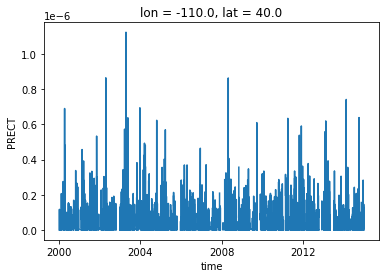

In [116]:
PRECT_filter.sel(lat=40,lon=-110).plot()

## Read and process daily sum precipitation to filter 3hrly precipitation timeseries

In [8]:
def process_PRECT_filter(path, file, landfrac, PRECT):
    
    # file made with CDO
    # these need to be opened as dataset for some reason (time bounds?)
    PRECT_daysum_ds = xr.open_dataset(path+file, chunks={'time':100, 'lat':10, 'lon':20})
    PRECT_daysum = PRECT_daysum_ds.PRECT
    
    # subset for a 15-year climatology (if applicable)
    if PRECT_daysum.shape[0] > 5475:
        PRECT_daysum = PRECT_daysum[:5475]
    
    # subset for land only (optional; comment out to use whole domain)
    #PRECT_daysum = PRECT_daysum.where(landfrac > 0)
    
    # daily sum precip (convert m/s to mm over a day)
    PRECT_daysum_mm = PRECT_daysum * 1000*60*60*3
    
    # filter out days with less than 1 mm
    PRECT_daysum_mm_filter = PRECT_daysum_mm.where(PRECT_daysum_mm > 1)
    
    # upscale the daily filtered data to match 3hr frequency
    # note that method 'nearest' is best here as 'linear' will cut off values
    PRECT_daysum_mm_filter_upscaled = PRECT_daysum_mm_filter.resample(time="3H").interpolate('nearest')
    
    # note that these time indices do not match the original 3hrly data since the upscaled filter is cut off at both ends
    # PRECT doesn't have to be modified, but it will produce something with modified time indices
    # Will need to adjust time indices of front data to match filtered data
    PRECT_filter = PRECT.where(PRECT_daysum_mm_filter_upscaled.notnull())
    
    return(PRECT_filter)

In [9]:
PRECT_daysum_file = 'PRECT_daysum_shift_NA_hist_rcp26_1deg_bil.nc' # file made with CDO, timeshift 1 hour backwards
PRECT_filter = process_PRECT_filter(postprocessing_filepath, PRECT_daysum_file, landfrac, PRECT)
PRECT_filter

,Array,Chunk
Bytes,3.13 GiB,0.92 MiB
Shape,"(43793, 68, 141)","(600, 10, 20)"
Count,53092 Tasks,4088 Chunks
Type,float64,numpy.ndarray


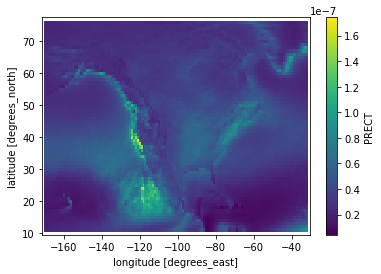

In [14]:
# filtered data definitely creates higher mean precip values, which will influence mean intensity analysis
(PRECT_filter.mean(dim='time') - PRECT.mean(dim='time')).plot()

In [10]:
PRECT_daysum_file_rcp = 'PRECT_daysum_NA_rcp85_1deg_bil.nc' # file made with CDO, no time shift needed for RCP file
PRECT_filter_rcp = process_PRECT_filter(postprocessing_filepath, PRECT_daysum_file_rcp, landfrac, PRECT_rcp)
PRECT_filter_rcp

,Array,Chunk
Bytes,3.13 GiB,0.92 MiB
Shape,"(43793, 68, 141)","(600, 10, 20)"
Count,45420 Tasks,4088 Chunks
Type,float64,numpy.ndarray


## Test the filtered precip data on the intensity/frequency breakdown plots and analysis
Does removing low precip days impact results?

### Read and process fronts given input file
All fronts and fronts by type

In [11]:
def process_fronts(path, file):
    fronts_ds = xr.open_dataset(path+file, chunks={'time':360})
    
    # convert longitudes to match CESM data (conservative regridding only)
    #fronts_ds_lons = fronts_ds.assign_coords(lon=(fronts_ds.lon % 360), keep_attrs=True)
    #fronts_ds_lons.lon.attrs = fronts_ds.lon.attrs
    #fronts = fronts_ds_lons.fronts
    
    fronts = fronts_ds.fronts
    #print(fronts.front_type.values)
    
    # subset for a 15-year climatology (if applicable)
    if fronts.shape[0] > 43800:
        fronts = fronts[:43800]
        
    # Adjust time indices to match filtered PRECT data
    fronts = fronts[3:-4]

    # all fronts
    allfronts = fronts.argmax(dim='front')
    anyfront = allfronts.where(allfronts < 4) # masking out no front areas
    
    # cold fronts
    allcoldfronts = fronts.sel(front=0) # see fronts.front_type.values for indices
    anycoldfront = allcoldfronts.where(allcoldfronts == 1) # masking out no cold front areas
    
    # warm fronts
    allwarmfronts = fronts.sel(front=1)
    anywarmfront = allwarmfronts.where(allwarmfronts == 1)
    
    # stationary fronts
    allstatfronts = fronts.sel(front=2)
    anystatfront = allstatfronts.where(allstatfronts == 1)
    
    # occluded fronts
    alloccfronts = fronts.sel(front=3)
    anyoccfront = alloccfronts.where(alloccfronts == 1)
    
    anyfront_types = xr.concat([anycoldfront, anywarmfront, anystatfront, anyoccfront], dim='front_type')
    
    return(anyfront, anyfront_types)

In [12]:
cesm_fronts_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
fronts_file = "cesm_fronts_2000-2015_MaskedNetCDF_customgrid.nc"
fronts, fronts_type = process_fronts(cesm_fronts_filepath, fronts_file)

In [18]:
fronts

<xarray.DataArray 'fronts' (time: 43793, lat: 68, lon: 141)>
dask.array<where, shape=(43793, 68, 141), dtype=float64, chunksize=(360, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0

In [13]:
fronts_file_rcp = "cesm_fronts_2086-2100_MaskedNetCDF_customgrid.nc"
fronts_rcp, fronts_type_rcp = process_fronts(cesm_fronts_filepath, fronts_file_rcp)

In [143]:
fronts_rcp

<xarray.DataArray 'fronts' (time: 43793, lat: 68, lon: 141)>
dask.array<where, shape=(43793, 68, 141), dtype=float64, chunksize=(360, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-01 09:00:00 ... 2100-12-31 09:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0

### Calculate fraction of total precipitation associated with a front

In [14]:
def calc_prect_front(PRECT, fronts, fronts_type):

    # precipitation overlapping with front
    PRECT_front = PRECT.where(fronts.notnull()).sum(dim='time')
    PRECT_front_type = PRECT.where(fronts_type.notnull()).sum(dim='time')
    
    # total precipitation
    PRECT_sum = PRECT.sum(dim='time')
    
    # proportion of precip overlapping with front
    PRECT_front_frac = 100*(PRECT_front/PRECT_sum)
    PRECT_front_frac_type = 100*(PRECT_front_type/PRECT_sum)
    
    # seasonal breakdown
    PRECT_front_byseason = PRECT.where(fronts.notnull()).groupby("time.season").sum(dim='time')
    PRECT_front_type_byseason = PRECT.where(fronts_type.notnull()).groupby("time.season").sum(dim='time')

    PRECT_sum_byseason = PRECT.groupby("time.season").sum(dim='time')
    
    PRECT_front_frac_byseason = 100*(PRECT_front_byseason/PRECT_sum_byseason)
    PRECT_front_frac_type_byseason = 100*(PRECT_front_type_byseason/PRECT_sum_byseason)
    
    #return(PRECT_front_frac, PRECT_front_frac_type)
    return(PRECT_front_frac_byseason, PRECT_front_frac_type_byseason)

In [15]:
# return seasonal values for plots
PRECT_front_frac, PRECT_front_frac_type = calc_prect_front(PRECT_filter, fronts, fronts_type)
PRECT_front_frac_rcp, PRECT_front_frac_type_rcp = calc_prect_front(PRECT_filter_rcp, fronts_rcp, fronts_type_rcp)

### Seasonal spatial plots

In [16]:
PRECT_front_frac_CONUS = PRECT_front_frac.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
print(PRECT_front_frac_CONUS.max().values)

94.30836463477405


In [17]:
PRECT_front_frac_CONUS_rcp = PRECT_front_frac_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
print(PRECT_front_frac_CONUS_rcp.max().values)

71.90771702662052


In [18]:
PRECT_front_frac_CONUS_diff = PRECT_front_frac_CONUS_rcp - PRECT_front_frac_CONUS
print(PRECT_front_frac_CONUS_diff.max().values)
print(PRECT_front_frac_CONUS_diff.min().values)

52.97923038598135
-94.30836463477405


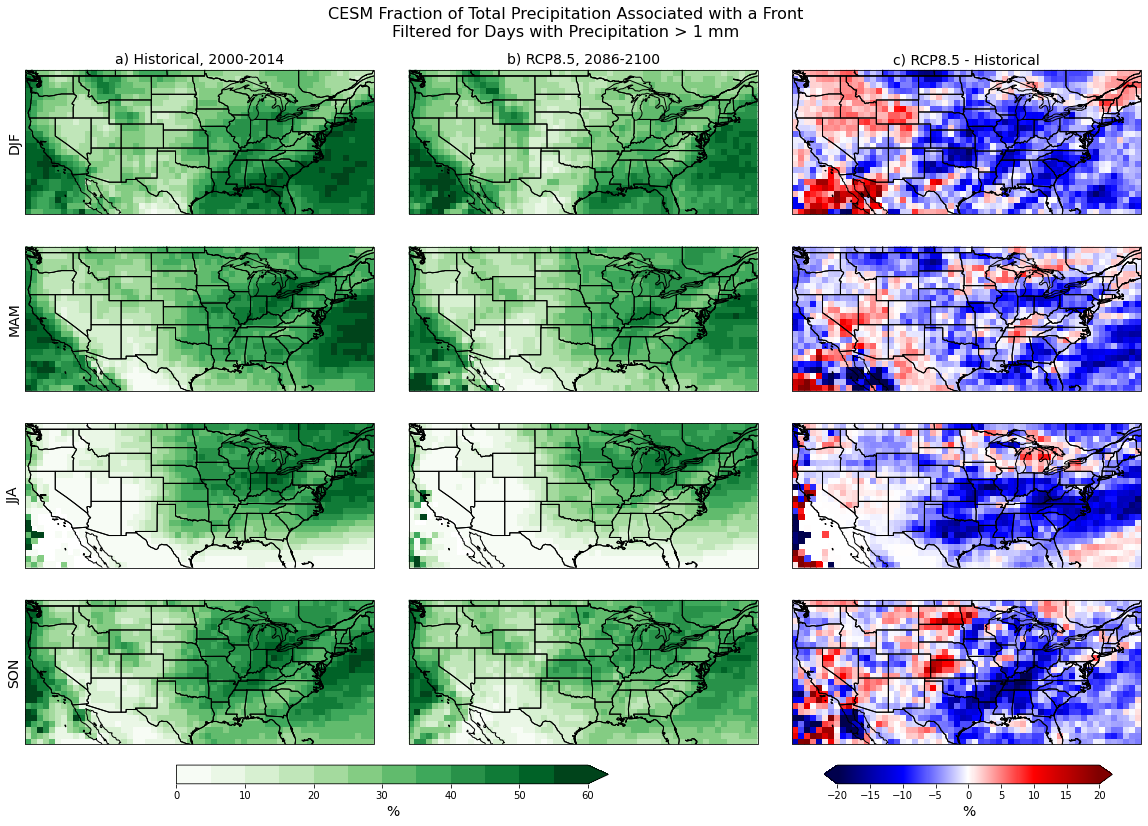

In [54]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 12)
vmax = 60

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(PRECT_front_frac_CONUS.sel(season=season), coord=PRECT_front_frac_CONUS.lon)
    lat = PRECT_front_frac_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,0].add_feature(cfeature.STATES, zorder=3)
    # add greyed out ocean
    #axs[i,0].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(PRECT_front_frac_CONUS_rcp.sel(season=season), coord=PRECT_front_frac_CONUS_rcp.lon)
    lat = PRECT_front_frac_CONUS_rcp.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.STATES, zorder=3)
    #axs[i,1].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
#cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb1.ax.set_xlabel('%', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-20
vmax2=20

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('c) RCP8.5 - Historical', fontsize=14)
    field, lon = add_cyclic_point(PRECT_front_frac_CONUS_diff.sel(season=season), coord=PRECT_front_frac_CONUS_diff.lon)
    lat = PRECT_front_frac_CONUS_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.STATES, zorder=3)
    #axs[i,2].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('%', fontsize=14)    
    
# add title

fig.suptitle('CESM Fraction of Total Precipitation Associated with a Front\nFiltered for Days with Precipitation > 1 mm', fontsize=16, y=0.93)

plt.subplots_adjust(wspace=0.1, hspace=0)

#plt.savefig('../figures/toSCP/PRECT_filter_frontfrac_hist_rcp_diff_CONUS.png', bbox_inches='tight', dpi=300)

### Calculate mean precipitation intensity associated with a front

In [19]:
def calc_prect_front_int(PRECT, fronts, fronts_type):

    # mean precipitation intensity overlapping with front
    PRECT_front_int = PRECT.where(fronts.notnull()).mean(dim='time')
    PRECT_front_int_type = PRECT.where(fronts_type.notnull()).mean(dim='time')
    
    # mean precip intensity
    PREC_int = PRECT.mean(dim='time')
    
    # seasonal breakdown
    PRECT_front_int_byseason = PRECT.where(fronts.notnull()).groupby("time.season").mean(dim='time')
    PRECT_front_int_type_byseason = PRECT.where(fronts_type.notnull()).groupby("time.season").mean(dim='time')

    PRECT_int_byseason = PRECT.groupby("time.season").mean(dim='time')
    
    return(PRECT_front_int_byseason, PRECT_front_int_type_byseason)

In [20]:
# return seasonal values for plots
PRECT_front_int, PRECT_front_int_type = calc_prect_front_int(PRECT_filter, fronts, fronts_type)
PRECT_front_int_rcp, PRECT_front_int_type_rcp = calc_prect_front_int(PRECT_filter_rcp, fronts_rcp, fronts_type_rcp)

In [21]:
Punits = 60*60*24*1000 # convert m/s to mm/day

In [22]:
PRECT_front_int_CONUS = PRECT_front_int.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
print(PRECT_front_int_CONUS.max().values*Punits)

61.69561039429074


In [46]:
PRECT_front_int_type_CONUS = PRECT_front_int_type.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()

In [23]:
PRECT_front_int_CONUS_rcp = PRECT_front_int_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
print(PRECT_front_int_CONUS_rcp.max().values*Punits)

105.64998450519569


In [47]:
PRECT_front_int_type_CONUS_rcp = PRECT_front_int_type_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()

In [24]:
PRECT_front_int_CONUS_diff = PRECT_front_int_CONUS_rcp - PRECT_front_int_CONUS
print(PRECT_front_int_CONUS_diff.max().values*Punits)
print(PRECT_front_int_CONUS_diff.min().values*Punits)

72.81102797495785
-22.655393850434827


In [48]:
PRECT_front_int_type_CONUS_diff = PRECT_front_int_type_CONUS_rcp - PRECT_front_int_type_CONUS

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-pac

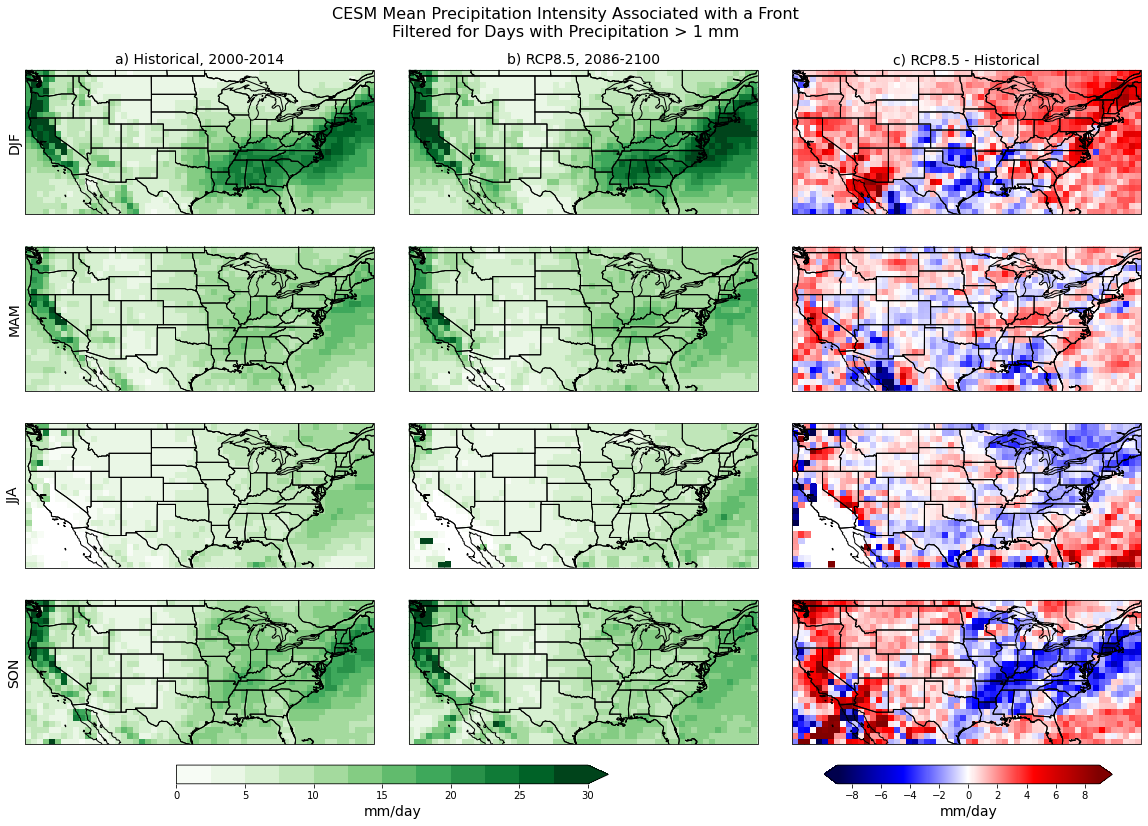

In [34]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 12)
vmax = 30

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(PRECT_front_int_CONUS.sel(season=season)*Punits, coord=PRECT_front_int_CONUS.lon)
    lat = PRECT_front_int_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,0].add_feature(cfeature.STATES, zorder=3)
    # add greyed out ocean
    #axs[i,0].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(PRECT_front_int_CONUS_rcp.sel(season=season)*Punits, coord=PRECT_front_int_CONUS_rcp.lon)
    lat = PRECT_front_int_CONUS_rcp.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.STATES, zorder=3)
    #axs[i,1].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
#cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb1.ax.set_xlabel('mm/day', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-9
vmax2=9

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('c) RCP8.5 - Historical', fontsize=14)
    field, lon = add_cyclic_point(PRECT_front_int_CONUS_diff.sel(season=season)*Punits, coord=PRECT_front_int_CONUS_diff.lon)
    lat = PRECT_front_int_CONUS_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.STATES, zorder=3)
    #axs[i,2].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('mm/day', fontsize=14)    
    
# add title

fig.suptitle('CESM Mean Precipitation Intensity Associated with a Front\nFiltered for Days with Precipitation > 1 mm', fontsize=16, y=0.93)

plt.subplots_adjust(wspace=0.1, hspace=0)

#plt.savefig('../figures/toSCP/PRECT_filter_frontint_hist_rcp_diff_CONUS.png', bbox_inches='tight', dpi=300)

### Calculate front frequency

In [25]:
def calc_front_freq(fronts, fronts_type):
    
    # number of timesteps with fronts relative to total timesteps
    front_freq = 100*(fronts.notnull().sum(dim='time')/len(fronts.time))
    front_freq_type = 100*(fronts_type.notnull().sum(dim='time')/len(fronts.time))
    
    # number of timesteps with fronts per season relative to timesteps in each season
    front_freq_byseason = 100*(fronts.notnull().groupby('time.season').sum(dim='time')/fronts.time.groupby('time.season').count())
    front_freq_type_byseason = 100*(fronts_type.notnull().groupby('time.season').sum(dim='time')/fronts.time.groupby('time.season').count())
    
    # return seasonal values
    return(front_freq_byseason, front_freq_type_byseason)

In [26]:
# return seasonal values for plots
front_freq, front_freq_type = calc_front_freq(fronts, fronts_type)
front_freq_rcp, front_freq_type_rcp = calc_front_freq(fronts_rcp, fronts_type_rcp)

In [27]:
front_freq_CONUS = front_freq.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()

In [40]:
front_freq_type_CONUS = front_freq_type.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()

In [28]:
front_freq_CONUS_rcp = front_freq_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()

In [43]:
front_freq_type_CONUS_rcp = front_freq_type_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()

In [29]:
front_freq_CONUS_diff = front_freq_CONUS_rcp - front_freq_CONUS

In [44]:
front_freq_type_CONUS_diff = front_freq_type_CONUS_rcp - front_freq_type_CONUS

### Calculate changes in frequency and intensity
Following Utsumi et al. (2016)

In [30]:
def calc_freq_int(front_freq, front_freq_diff, PRECT_front_int, PRECT_front_int_diff):
    
    # PRECT unit conversion m/s to mm/day
    Punits = 60*60*24*1000
    
    # change due to the frequency change, change in front frequency * mean precip intensity per event (mm/day) historical climate
    # "frequency term" in mm/day
    freq_term = (front_freq_diff/100) * (PRECT_front_int*Punits)
    
    # change due to the intensity change, front frequency historical climate * change in mean precip intensity per event (mm/day)
    # "intensity term" in mm/day
    int_term = (front_freq/100) * (PRECT_front_int_diff*Punits)
    
    # covariation term, change in front frequency * change in mean precip intensity per event (mm/day)
    cov_term = (front_freq_diff/100) * PRECT_front_int_diff*Punits
    
    # change in the total precipitation for fronts, mm/day
    delta_P = freq_term + int_term + cov_term
    
    return(freq_term, int_term, cov_term, delta_P)

In [31]:
freq_term, int_term, cov_term, delta_P = calc_freq_int(front_freq_CONUS, front_freq_CONUS_diff, PRECT_front_int_CONUS, PRECT_front_int_CONUS_diff)

In [32]:
print(freq_term.max().values, freq_term.min().values)

1.4147405254494145 -1.6408014653808192


In [33]:
print(int_term.max().values, int_term.min().values)

2.123654982602937 -1.2764022898607221


In [34]:
print(cov_term.max().values, cov_term.min().values)

0.4232326323707603 -1.932394130132486


In [35]:
print(delta_P.max().values, delta_P.min().values)

1.4292945145274072 -1.7170242131048832


/glade/scratch/kdagon/ipykernel_23512/1630411946.py:49: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap, norm=norm2, orientation='horizontal', extend='both')


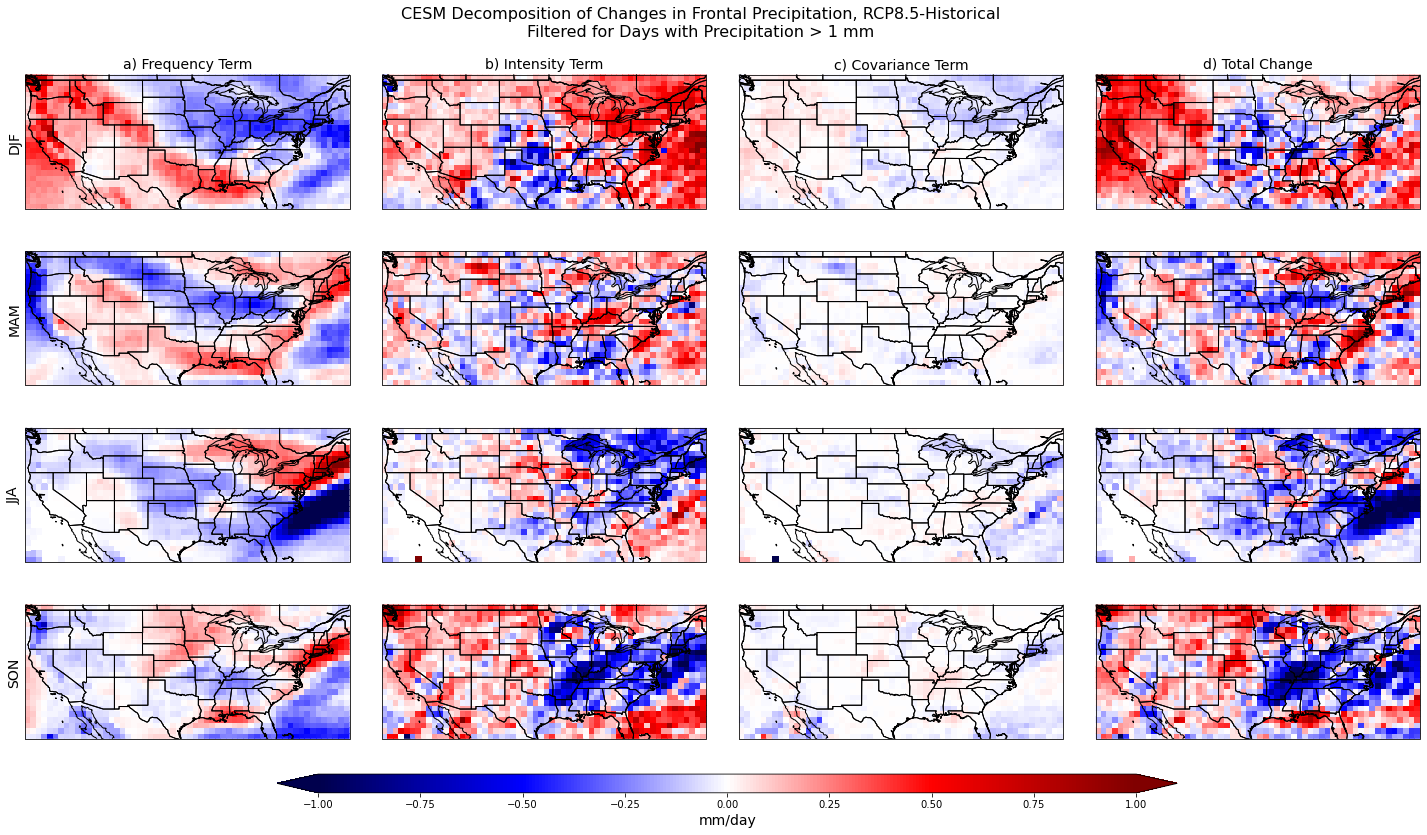

In [47]:
# spatial plots by season
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 4, figsize=(25,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('seismic')

# Frequency term
vmin1=-1
vmax1=1

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,0].set_title('a) Frequency Term', fontsize=14)
    field, lon = add_cyclic_point(freq_term.sel(season=season), coord=freq_term.lon)
    lat = freq_term.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin1, vmax=vmax1, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,0].add_feature(cfeature.STATES, zorder=3)
    #axs[i,0].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

# First colorbar
#cb1_ax = fig.add_axes([0.145, 0.08, 0.2, 0.02])
#norm1 = mpl.colors.Normalize(vmin=vmin1, vmax=vmax1)
#cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm1, orientation='horizontal', extend='both')
#cb1.ax.set_xlabel('mm/day', fontsize=14)

# Intensity term
vmin2=-1
vmax2=1

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,1].set_title('b) Intensity Term', fontsize=14)
    field, lon = add_cyclic_point(int_term.sel(season=season), coord=int_term.lon)
    lat = int_term.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.STATES, zorder=3)
    #axs[i,1].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# Second colorbar
cb2_ax = fig.add_axes([0.265, 0.09, 0.5, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('mm/day', fontsize=14)

# Covariance term
vmin3=-1
vmax3=1

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('c) Covariance Term', fontsize=14)
    field, lon = add_cyclic_point(cov_term.sel(season=season), coord=cov_term.lon)
    lat = cov_term.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin3, vmax=vmax3, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.STATES, zorder=3)
    #axs[i,2].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# Third colorbar
#cb3_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
#norm3 = mpl.colors.Normalize(vmin=vmin3, vmax=vmax3)
#cb3 = mpl.colorbar.ColorbarBase(cb3_ax, cmap, norm=norm3, orientation='horizontal', extend='both')
#cb3.ax.set_xlabel('mm/day', fontsize=14)

# Total change
vmin4=-1
vmax4=1

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,3].set_title('d) Total Change', fontsize=14)
    field, lon = add_cyclic_point(delta_P.sel(season=season), coord=delta_P.lon)
    lat = delta_P.lat
    cf = axs[i,3].pcolor(lon, lat, field, cmap=cmap, vmin=vmin4, vmax=vmax4, transform=ccrs.PlateCarree())
    axs[i,3].coastlines(zorder=1)
    axs[i,3].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,3].add_feature(cfeature.STATES, zorder=3)
    #axs[i,3].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

plt.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle('CESM Decomposition of Changes in Frontal Precipitation, RCP8.5-Historical\nFiltered for Days with Precipitation > 1 mm', fontsize=16, y=0.93);

#plt.savefig('../figures/toSCP/CESM_frontalPRECT_filter_freq_int_cov_total.png', bbox_inches='tight', dpi=300)

/glade/scratch/kdagon/ipykernel_23512/1232297644.py:53: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal', extend='both')


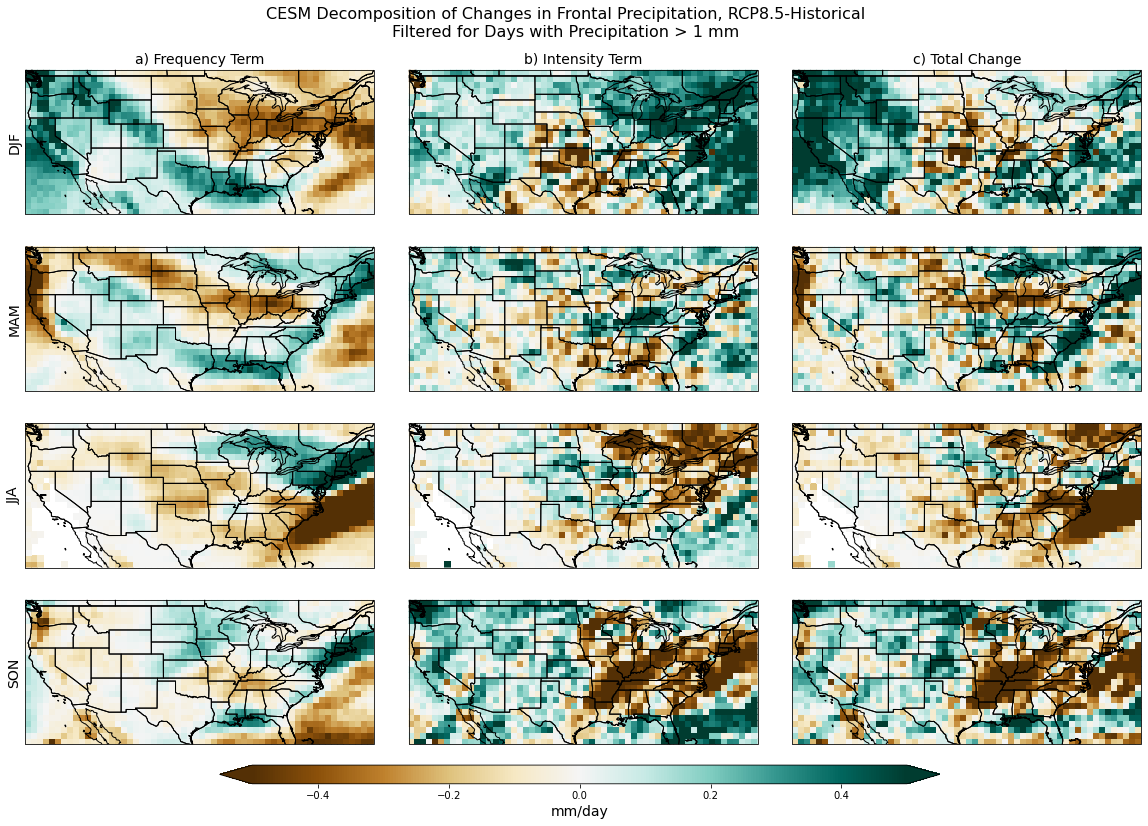

In [48]:
# removing covariance term (small)
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('BrBG')

# Constant scaling
vmin=-0.5
vmax=0.5

# Frequency term
for i, season in enumerate(seastrings):
    if i==0:
        axs[i,0].set_title('a) Frequency Term', fontsize=14)
    field, lon = add_cyclic_point(freq_term.sel(season=season), coord=freq_term.lon)
    lat = freq_term.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,0].add_feature(cfeature.STATES, zorder=3)
    #axs[i,0].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

# Intensity term
for i, season in enumerate(seastrings):
    if i==0:
        axs[i,1].set_title('b) Intensity Term', fontsize=14)
    field, lon = add_cyclic_point(int_term.sel(season=season), coord=int_term.lon)
    lat = int_term.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.STATES, zorder=3)
    #axs[i,1].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# Total change
for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('c) Total Change', fontsize=14)
    field, lon = add_cyclic_point(delta_P.sel(season=season), coord=delta_P.lon)
    lat = delta_P.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.STATES, zorder=3)
    #axs[i,2].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# common colorbar
cb_ax = fig.add_axes([0.26, 0.1, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb.ax.set_xlabel('mm/day', fontsize=14)
    
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle('CESM Decomposition of Changes in Frontal Precipitation, RCP8.5-Historical\nFiltered for Days with Precipitation > 1 mm', fontsize=16, y=0.93);

#plt.savefig('../figures/toSCP/CESM_frontalPRECT_filter_freq_int_total.png', bbox_inches='tight', dpi=300)

### By front type

In [49]:
freq_term_type, int_term_type, cov_term_type, delta_P_type = calc_freq_int(front_freq_type_CONUS, front_freq_type_CONUS_diff, PRECT_front_int_type_CONUS, PRECT_front_int_type_CONUS_diff)

### Spatial means for bar charts

In [36]:
def spatial_mean(array):
    
    weights = np.cos(np.deg2rad(array.lat))
    weights.name = "weights"
    array_weighted = array.weighted(weights)
    array_weighted_mean = array_weighted.mean(("lon","lat"))
    
    return(array_weighted_mean)

In [50]:
freq_term_type_mean = spatial_mean(freq_term_type)
int_term_type_mean = spatial_mean(int_term_type)
delta_P_type_mean = spatial_mean(delta_P_type)

In [54]:
freq_term_type_mean[:,0].values

array([-0.03351054,  0.03463865,  0.01847588,  0.01012234])

In [52]:
import matplotlib.patches as mpatches

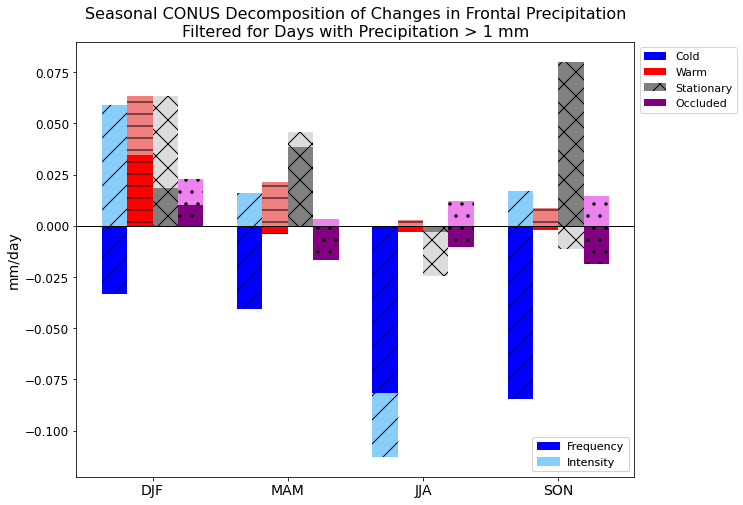

In [56]:
fig, ax = plt.subplots(figsize=(10,8))

seastrings = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(seastrings)
x = np.arange(nseason)  # the label locations

flabels = ['Cold', 'Warm', 'Stationary', 'Occluded']
ftypes = ['cold', 'warm', 'stationary', 'occluded']
# number of bars per xlabel
nbars = len(flabels)
# width
w = 0.75/nbars

fcolors=['blue','red','grey','purple']
icolors=['lightskyblue','lightcoral','gainsboro','violet']
hatches=['/','-','x','.']

bottom = np.zeros((nbars,nseason))

# loop over fronts
for i,f in enumerate(ftypes):

    position = x + (w*(1-nbars)/2) + i*w
    
    # loop over seasons
    for j,s in enumerate(seastrings):
        
        # legend label for first season only
        if j==0:
            ax.bar(position[j], freq_term_type_mean.sel(front_type=f, season=s), width=w, label=flabels[i], color=fcolors[i], hatch=hatches[i])
        else:
            ax.bar(position[j], freq_term_type_mean.sel(front_type=f, season=s), width=w, color=fcolors[i], hatch=hatches[i])
            
        # define bottom for stacked bar chart
        if np.sign(freq_term_type_mean.sel(front_type=f, season=s)) == np.sign(int_term_type_mean.sel(front_type=f,season=s)):
            bottom[i,j] = freq_term_type_mean.sel(front_type=f, season=s)
        else:
            bottom[i,j] = 0
        ax.bar(position[j], int_term_type_mean.sel(front_type=f, season=s), width=w, color=icolors[i], hatch=hatches[i], bottom=bottom[i,j])



ax.set_title('Seasonal CONUS Decomposition of Changes in Frontal Precipitation\nFiltered for Days with Precipitation > 1 mm', fontsize=16)
ax.set_ylabel('mm/day', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticks(x)
ax.set_xticklabels(seastrings, fontsize=14)
ax.axhline(y=0, color='black', lw=1)
legend1 = ax.legend(bbox_to_anchor=(1, 1), fontsize=11)
plt.gca().add_artist(legend1)

# first legend 
#cold_patch = mpatches.Patch(color='blue', hatch='/', label='Cold')
#warm_patch = mpatches.Patch(color='red', hatch='-', label='Warm')
#stat_patch = mpatches.Patch(color='grey', hatch='x', label='Stationary')
#occ_patch = mpatches.Patch(color='purple', hatch='.', label='Occluded')
#handles=[cold_patch,warm_patch,stat_patch,occ_patch]
#legend1 = plt.legend(handles, loc=1, fontsize=11)
#plt.gca().add_artist(legend1)

# second legend
freq_patch = mpatches.Patch(color='blue', label='Frequency')
int_patch = mpatches.Patch(color='lightskyblue', label='Intensity')
legend2 = plt.legend(handles=[freq_patch, int_patch], loc=4, fontsize=11)

# add second legend
plt.gca().add_artist(legend2)

#plt.savefig('../figures/toSCP/CESM_CONUS_mean_filter_freq_int_fronttype.png', bbox_inches='tight', dpi=300)

### Calculate mean changes in precipitation

In [49]:
# mean change in precipitation, mm/day
# by simple averaging over all 3hrly filtered time points
mean_PRECT_CONUS = ((PRECT_filter_rcp.mean(dim='time') - PRECT_filter.mean(dim='time'))*Punits).sel(lat=slice(26,50), lon=slice(-125,-68))

In [50]:
# mean change in precip by season, mm/day
mean_PRECT_CONUS_byseason = ((PRECT_filter_rcp.groupby('time.season').mean(dim='time') - PRECT_filter.groupby('time.season').mean(dim='time'))*Punits).sel(lat=slice(26,50), lon=slice(-125,-68))

In [51]:
print(mean_PRECT_CONUS_byseason.max().values, mean_PRECT_CONUS_byseason.min().values)

15.680558211110997 -7.777524312103569


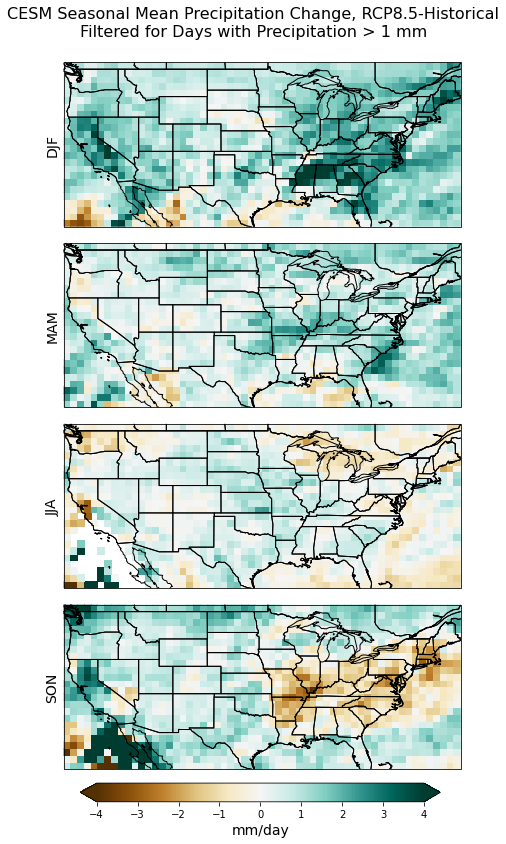

In [53]:
# comparing PRECT seasonal changes computed without fronts
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 1, figsize=(10,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('BrBG')

vmin=-4
vmax=4

for i, season in enumerate(seastrings):
    #if i==0:
        #axs[i,0].set_title('a) Frequency Term', fontsize=14)
    field, lon = add_cyclic_point(mean_PRECT_CONUS_byseason.sel(season=season), coord=mean_PRECT_CONUS_byseason.lon)
    lat = mean_PRECT_CONUS_byseason.lat
    cf = axs[i].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.BORDERS, zorder=2)
    axs[i].add_feature(cfeature.STATES, zorder=3)
    #axs[i].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    
cb_ax = fig.add_axes([0.26, 0.09, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='both')
cb.ax.set_xlabel('mm/day', fontsize=14)  

fig.suptitle('CESM Seasonal Mean Precipitation Change, RCP8.5-Historical\nFiltered for Days with Precipitation > 1 mm', fontsize=16, y=0.94)
plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('../figures/toSCP/CESM_season_mean_PRECT_filter_diff.png', bbox_inches='tight', dpi=300)

### Contribution of fronts to mean change in precipitation

In [55]:
Cnt_fronts = delta_P/abs(mean_PRECT_CONUS_byseason)

In [56]:
Cnt_fronts

<xarray.DataArray (season: 4, lat: 25, lon: 58)>
dask.array<truediv, shape=(4, 25, 58), dtype=float64, chunksize=(1, 10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat      (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 46.0 47.0 48.0 49.0 50.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [57]:
print(Cnt_fronts.max().values, Cnt_fronts.min().values)

185.37722086261522 -1645.304263726054


/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


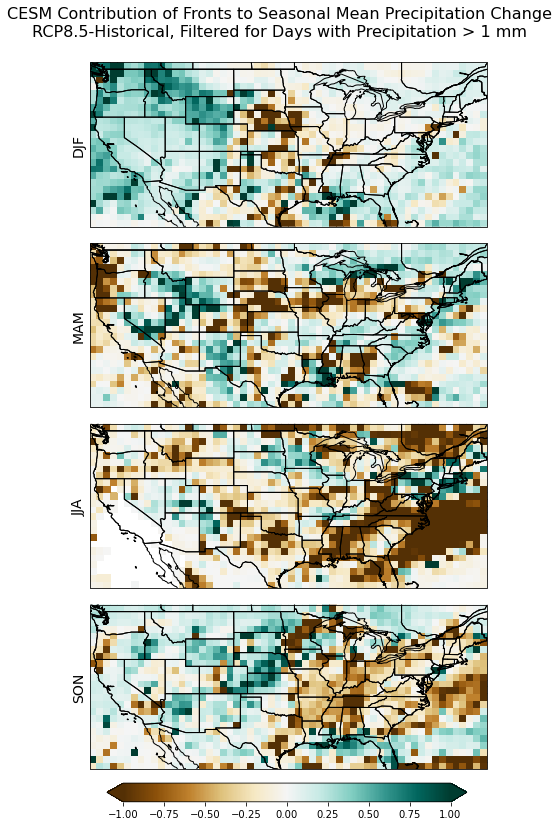

In [58]:
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 1, figsize=(10,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('BrBG')

vmin=-1
vmax=1

for i, season in enumerate(seastrings):
    #if i==0:
        #axs[i,0].set_title('a) Frequency Term', fontsize=14)
    field, lon = add_cyclic_point(Cnt_fronts.sel(season=season), coord=Cnt_fronts.lon)
    lat = Cnt_fronts.lat
    cf = axs[i].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.BORDERS, zorder=2)
    axs[i].add_feature(cfeature.STATES, zorder=3)
    #axs[i].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    
cb_ax = fig.add_axes([0.26, 0.09, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='both')
#cb.ax.set_xlabel('', fontsize=14)  

fig.suptitle('CESM Contribution of Fronts to Seasonal Mean Precipitation Change\nRCP8.5-Historical, Filtered for Days with Precipitation > 1 mm', fontsize=16, y=0.94)
plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('../figures/toSCP/CESM_Cnt_fronts_filter.png', bbox_inches='tight', dpi=300)